<Figure size 640x480 with 0 Axes>

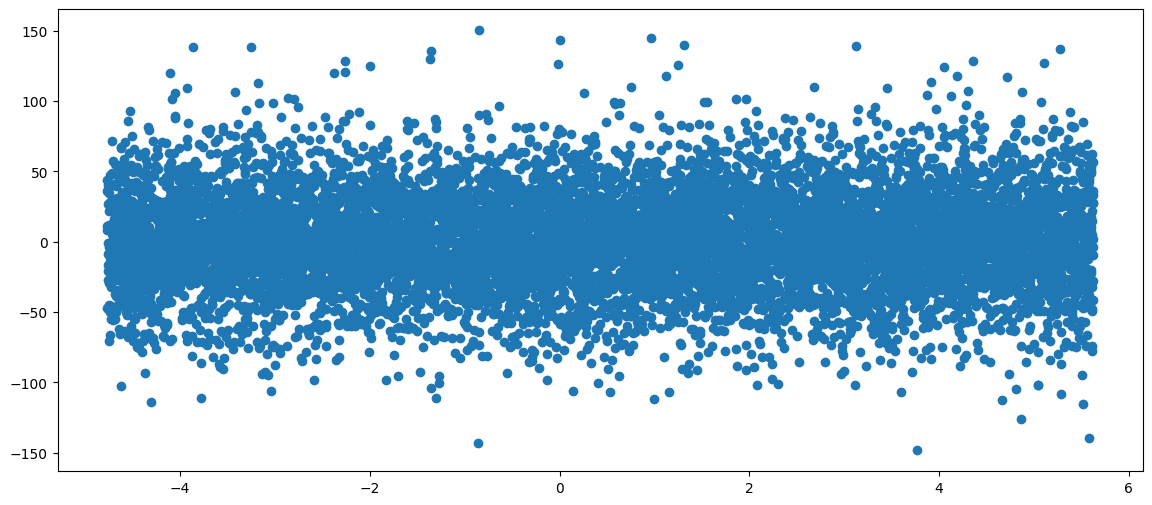

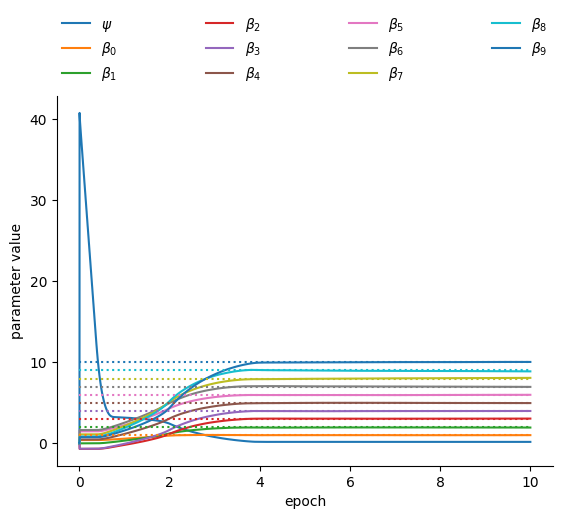

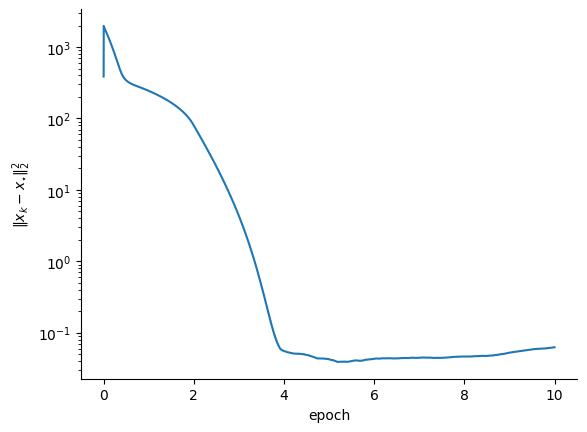

In [21]:
from autograd import grad
import autograd.numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

def _robust_loss(psi, beta, nu, Y, Z):
    scaled_sq_errors = np.exp(-2*psi)  * (np.dot(Z, beta) - Y)**2
    if nu == np.inf:
        return scaled_sq_errors/2 + psi
    return (nu + 1)/2 * np.log(1 + scaled_sq_errors / nu) + psi


def make_sgd_robust_loss(Y, Z, nu):
    N = Y.size
    sgd_loss = lambda param, inds: np.mean(_robust_loss(param[0], param[1:], nu, Y[inds], Z[inds])) + np.sum(param**2)/(2*N)
    grad_sgd_loss = grad(sgd_loss)
    return sgd_loss, grad_sgd_loss


def generate_data(N, D, seed):
    rng = np.random.default_rng(seed)
    # generate multivariate t covariates with 10 degrees
    # of freedom and non-diagonal covariance 
    t_dof = 10
    locs = np.arange(D).reshape((D,1))
    cov = (t_dof - 2) / t_dof * np.exp(-(locs - locs.T)**2/4)
    Z = rng.multivariate_normal(np.zeros(D), cov, size=N)
    Z *= np.sqrt(t_dof / rng.chisquare(t_dof, size=(N, 1)))
    # generate responses using regression coefficients beta = (1, 2, ..., D)
    # and t-distributed noise 
    true_beta = np.arange(1, D+1)
    Y_n = Z.dot(true_beta) + rng.standard_t(t_dof, size=N)
    # for simplicity, center responses 
    Y = Y_n - np.mean(Y_n)
    return true_beta, Y, Z, Y_n


def run_SGD(grad_loss, epochs, init_param, init_stepsize, stepsize_decayrate, batchsize, N):
    K = (epochs * N) // batchsize
    D = init_param.size
    paramiters = np.zeros((K+1,D))
    paramiters[0] = init_param
    for k in range(K):
        inds = np.random.choice(N, batchsize)
        stepsize = init_stepsize / (k+1)**stepsize_decayrate
        if k == 0:
            stepsize = 5
        paramiters[k+1] = paramiters[k] - stepsize*grad_loss(paramiters[k], inds)
        
    return paramiters

def run_SGD_iterate_avg(grad_loss, epochs, init_param, init_stepsize, stepsize_decayrate, batchsize, N):
    K = (epochs * N) // batchsize
    D = init_param.size
    paramiters = np.zeros((K+1,D))
    out_param = np.zeros((K+1,D))
    paramiters[0] = init_param
    out_param[0] = init_param
    for k in range(K):
        inds = np.random.choice(N, batchsize)
        stepsize = init_stepsize / (k+1)**stepsize_decayrate
        if k == 0:
            stepsize = 5
        paramiters[k+1] = paramiters[k] - stepsize*grad_loss(paramiters[k], inds)
        l = int(np.floor(k/2))
        out_sum = init_param
        for i in range(l,k+1):
            out_sum = np.add(out_sum,paramiters[i])
        out_param[k+1] = 1 / (np.ceil(k/2 + 1)) * out_sum
    
        
    return out_param



def plot_iterates_and_squared_errors(paramiters, true_beta, opt_param, skip_epochs, epochs, N, batchsize, include_psi=True):
    D = true_beta.size
    param_names = [r'$\beta_{{{}}}$'.format(i) for i in range(D)]
    if include_psi:
        param_names = [r'$\psi$'] + param_names
    else:
        paramiters = paramiters[:,1:]
        opt_param = opt_param[1:]
    skip_epochs = 0
    skip_iters = int(skip_epochs*N//batchsize)
    xs = np.linspace(skip_epochs, epochs, paramiters.shape[0] - skip_iters)
    plt.plot(xs, paramiters[skip_iters:]);
    plt.plot(np.array(D*[[xs[0], xs[-1]]]).T, np.array([true_beta,true_beta]), ':')
    plt.xlabel('epoch')
    plt.ylabel('parameter value')
    plt.legend(param_names, bbox_to_anchor=(0,1.02,1,0.2), loc='lower left',
               mode='expand', borderaxespad=0, ncol=4, frameon=False)
    sns.despine()
    plt.show()
    plt.plot(xs, np.linalg.norm(paramiters - opt_param[np.newaxis,:], axis=1)**2)
    plt.xlabel('epoch')
    plt.ylabel(r'$\|x_k - x_{\star}\|_2^2$')
    plt.yscale('log')
    sns.despine()
    plt.show()
    
    
    
# Driver Code
D = 10
nu = 15
init_s = 0
init_param = np.zeros(D+1)
init_param[0] = init_s
init_step = 4
step_decay_rate = 0
B = 10
N = 10000

true_beta, Y, Z, Y_n = generate_data(N,D,5) # z are the features; 10-dimensional, Y is the response
loss, grad_loss = make_sgd_robust_loss(Y,Z,nu)

FIG_WIDTH = 14
FIG_HEIGHT = 6 

# Data Visualization
plt.figure(0)
plt.figure(figsize=(FIG_WIDTH,FIG_HEIGHT))
beta_i = 5

a = min(Z[:,beta_i])
b = max(Z[:,beta_i])
dt = np.linspace(a,b,N)
plt.scatter(dt,Y_n)
plt.show()


#===SGD with constant step size===
init_s = 1
init_param = np.zeros(D+1)
init_param[0] = init_s
epochs = 10
init_step = 0.1
step_decay_rate = 0
skip_epochs = 0
opt_param = np.insert(true_beta,0,0)
#true_beta = [1,...10]
#B = 10
#N = 10000

param = run_SGD(grad_loss,epochs,init_param,init_step,step_decay_rate,B,N)
plot_iterates_and_squared_errors(param,true_beta,opt_param,skip_epochs,epochs,N,B)

#===SGD with constant step size and iterate averaging===
#init_s = 1
#init_param = [0,...,0]
#epochs = 10
#init_step = 0.1
#step_decay_rate = 0
#skip_epochs = 0
#opt_param = [0,...,10]
#true_beta = [1,...,10]
#B = 10
#N = 10000

param = run_SGD_iterate_avg(grad_loss,epochs,init_param,init_step,step_decay_rate,B,N)
plot_iterates_and_squared_errors(param,true_beta,opt_param,skip_epochs,epochs,N,B)

#===SGD with decreasing step size
#init_s = 1
#init_param = [0,...,0]
#epochs = 10
#init_step = 0.1
step_decay_rate = 0.51
#skip_epochs = 0
#opt_param = [0,...,10]
#true_beta = [1,...,10]
#B = 10
#N = 10000

param = run_SGD(grad_loss,epochs,init_param,init_step,step_decay_rate,B,N)
plot_iterates_and_squared_errors(param,true_beta,opt_param,skip_epochs,epochs,N,B)